### Allele Frequency Trajectories

In [248]:
import numpy as np
import os as os
import sys as sys
import multiprocessing as mp
import pandas as pd
import socket
import matplotlib.pyplot as plt
from itertools import groupby
from shutil import which
import os
import re as re
from matplotlib import gridspec
from datetime import date

### Pick the right path (whether on cluster or at home)
socket_name = socket.gethostname()
print(f"Current machine: {socket_name}")
if socket_name == "DESKTOP-5RJD9NC":
    path = "/gitProjects/covid19_data"   # The Path on Harald's machine
if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/covid19_data/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
### For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)
rcParams['axes.linewidth'] = 0.2  # Set the Default Size of the Boundary for small 2.25in width figures
    
### Check whether required bins are available
req_bins = ["mafft"] 
for b in req_bins:
    s = which(b)
    if not s:
        print(f"Make sure to install {b} and have in path. I cannot find it!")
        
os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())

sys.path.append("./python3/")
from manipulate_fasta import fasta_iter_raw, fasta_iter

Current machine: compute-a-16-161.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/covid19_data


### Define Functions

In [250]:
def load_merged_df(var_path="./output/tables/derived_common_snps.tsv",
                   meta_path="./data/apr20/metadata.tsv",
                   epi_col = "gisaid_epi_isl"):
    """Load variant df and meta df, and merge on epi_col"""
    df = pd.read_csv(var_path, sep="\t")
    df[epi_col] = df["iid"].str.split("|").str[1]  # Split out the EPI ID
    df_meta = pd.read_csv(meta_path, sep="\t")
    df1 = pd.merge(df, df_meta, on=epi_col)
    print(f"Merged to {len(df1)}/{len(df)} Individuals")
    return df1

### Load the variant Data

In [251]:
df1 = load_merged_df(var_path="./output/tables/derived_common_snps.tsv",
                     meta_path="./data/apr20/metadata.tsv")
df1 = df1[~(df1["date"]=="2020-02-XX")].copy() # Throw out garbage data
df1 = df1[~(df1["date"]=="2020-01-XX")].copy() # Throw out garbage data
df1 = df1[~(df1["date"]=="2020-03-XX")].copy() # Throw out garbage data
df1 = df1[~(df1["date"]=="2020-01-01")].copy()
df1["date1"] =  pd.to_datetime(df1["date"]) # New Sort Column
print(f"Thrown out data with inaccurate dates, now: {len(df1)}")

Merged to 12691/15056 Individuals
Thrown out data with inaccurate dates, now: 12667


In [252]:
### Experiments to establish what is missing
df = pd.read_csv("./output/tables/derived_common_snps.tsv", sep="\t")
idx =[iid not in df1["iid"].values for iid in df["iid"]]

df_meta = pd.read_csv("./data/apr20/metadata.tsv", sep="\t")
cts = df[idx]["iid"].str.split("/").str[1]
cts.value_counts()

#found = df_meta["gisaid_epi_isl"].str.contains("433498")
#np.sum(found)

England        921
Scotland       566
Wales          456
USA            300
Belgium         39
Greece          32
Luxembourg      29
China           17
Germany         12
Netherlands      6
Wuhan            5
South Korea      1
Korea            1
Switzerland      1
Canada           1
JOR              1
France           1
Name: iid, dtype: int64

### Plot Cumulative Frequency

In [253]:
df2 = df1.copy()
pos= f"23402"
flip = True

df2 = df2[df2["date1"]!="2020-01-01"]
df2 = df2.sort_values(by="date1")
df2 = df2[df2['host']=="Human"]
print(f"Human Samples: {len(df2)}")
derived = df2[pos]

if flip:
    derived= ~derived

dts = df2["date1"]
cum_count = np.arange(len(df2))+1
cum_der = np.cumsum(derived)
all_freq = cum_der / cum_count

Human Samples: 12590


Saved to ./figures/dumpster/all_freq_full.png


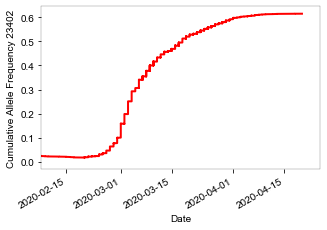

In [258]:
savepath="./figures/dumpster/all_freq_full.png"

plt.figure(figsize=(5,3))
ax=plt.gca()
ax.plot(dts, all_freq, lw=2, c="r")

ax.set_ylabel(f"Cumulative Allele Frequency {23402}")
ax.set_xlabel("Date")
plt.xticks(rotation=30, ha='right')
#ax.set_xlim([date("2020-02-01"), date("2020-04-01")])
ax.set_xlim([date(2020, 2, 8), date(2020, 4, 25)])
if len(savepath)>0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=200)
    print(f"Saved to {savepath}")

plt.show()

In [43]:
def plot_freq_traj_group(savepath="./figures/dumpster/all_freq_country_april.png",
                         figsize=(12,4), pos= f"23402", flip=False, min_cases = 10, col = "country",
                         countries = ["Netherlands", "United Kingdom", "France", "Belgium", 
                                      "Switzerland", "Germany", "Luxembourg", "USA", "Canada", "Australia", "China"]):
    plt.figure(figsize=figsize)
    ax=plt.gca()

    for ctry in countries:
        df_t = df2[df2[col]==ctry]

        derived = df_t[pos]
        if flip:
            derived = ~derived
        dts = df_t["date1"]
        cum_count = np.arange(len(df_t))+1
        cum_der = np.cumsum(derived)
        all_freq = cum_der / cum_count

        ax.plot(dts[min_cases:], all_freq[min_cases:], label=ctry)

    #plt.plot(date, cum_count)
    ax.set_ylabel(f"Cumulative Allele Frequency {23402}")
    ax.set_xlabel("Date")
    ax.set_xlim([date(2020, 2, 15), date(2020, 5, 15)])
    ax.legend(loc = "upper right")
    plt.xticks(rotation=30, ha='right')

    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', 
                    pad_inches = 0, dpi=200)
        print(f"Saved to {savepath}")
    plt.show()

Saved to ./figures/dumpster/all_freq_country_april.png


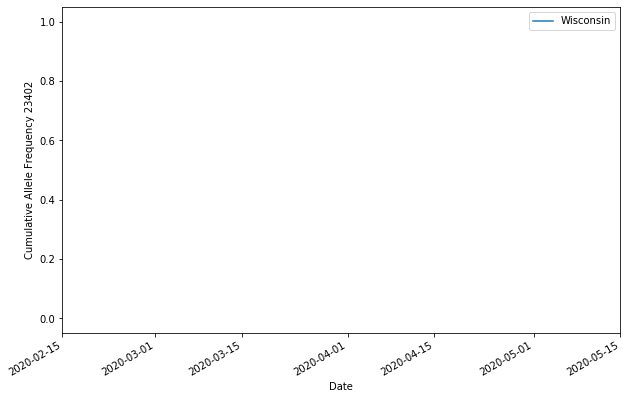

In [117]:
countries = ["Netherlands", "United Kingdom", "Iceland", "France", "Spain", "Belgium", 
                                  "Switzerland", "Germany", "Belgium", "Luxembourg", "USA", "Canada", "Australia", 
                                  "China"]

countries = ["Wisconsin"]

plot_freq_traj_group(figsize=(10,6), savepath="./figures/dumpster/all_freq_country_april.png",
                     pos= f"3036", min_cases = 10, col = "country",
                     countries = countries, flip=True)

Saved to ./figures/dumpster/all_freq_country_april.png


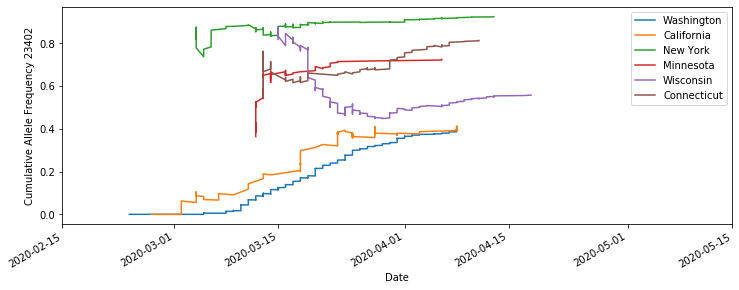

In [128]:
countries = ["Washington", "Reykjavik", "England", "Wales",
             "Auvergne-Rhône-Alpes", "North Brabant", "Ontario", "Portugal",
             "Minnesota", "New York", "California", "New York"]
countries=["Washington", "California", "New York", "Minnesota", "Wisconsin", "Connecticut"]

plot_freq_traj_group(savepath="./figures/dumpster/all_freq_country_april.png",
                     pos= f"23402", min_cases = 10, col = "division",
                     countries = countries, flip=True)

In [ ]:
df2["Ontario"].value_counts()

In [ ]:
df2["division"].value_counts()[:]

In [88]:
df1["host"].value_counts()

Human                       12649
Manis javanica                  8
Environment                     5
Panthera tigris jacksoni        1
Rhinolophus affinis             1
Rhinolophus malayanus           1
unknown                         1
Mustela lutreola                1
Name: host, dtype: int64

In [89]:
np.corrcoef(df1["14407"], df1["23402"]) # "3036", "14407" "23402"

array([[1.        , 0.98438036],
       [0.98438036, 1.        ]])

# Plot Diagrams

In [315]:
def plot_freq_traj_ax(ax, df, ctry, pos= f"23402", xlim=[], left=True, bottom=True,
                      flip=False, min_cases = 10, col = "country", hist=True,
                      c="r", savepath="", ylim=[], lw=3, fs_l=12, show=False,
                      txt_xy=(0.97, 0.48)):
    plt.xticks(rotation=30, ha='right')
    df_t = df[df[col]==ctry]

    derived = df_t[pos]
    if flip:
        derived = ~derived
    dts = df_t["date1"]
    cum_count = np.arange(len(df_t))+1
    cum_der = np.cumsum(derived)
    all_freq = cum_der / cum_count

    ax.plot(dts[min_cases:], all_freq[min_cases:], label=ctry, lw=lw)
    ax.set_yticks([0,0.25,0.5, 0.75])
    #plt.plot(date, cum_count)
        
    ax.set_xlim(xlim)
    if len(ylim)>0:
        ax.set_ylim(ylim)
    #ax.legend(fontsize=fs_l)
    label = f"{ctry}\n n={len(df_t)}"
    ax.text(txt_xy[0], txt_xy[1], label, horizontalalignment='right', zorder=10,
            verticalalignment='top', transform=ax.transAxes, fontsize=fs_l)
    ax.grid(linestyle='--', lw=0.5)
    
    if hist:
        ax2=ax.twinx()
        ax2.set_ylim([0,0.3])
        ax2.set_yticks([])
        ax2.hist(df_t["date1"], density=True, range=xlim, 
                 bins=20, ec="k", alpha=0.3, color="gray", zorder=0)
    
    
    ### Do the labels
    if left:
        ax.set_ylabel(f"Cum Frequency {23402}")
    else:
        ax.set_yticklabels([])
    
    if bottom:
        ax.set_xlabel("Date")
        
    else: 
        ax.set_xticklabels([])

    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', 
                    pad_inches = 0, dpi=200)
        print(f"Saved to {savepath}")
    if show:
        plt.show()

In [ ]:
plt.hist()

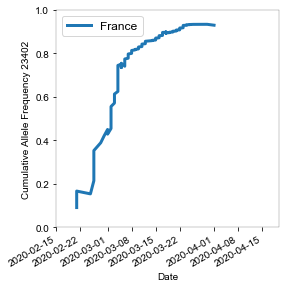

In [157]:
xlim = [date(2020, 2, 15), date(2020, 4, 20)]
ylim=[0,1]

fig = plt.figure(figsize=(4,4))
ax = plt.gca()
plot_freq_traj_ax(ax, df2, ctry="France", xlim=xlim, ylim=ylim, fs_l=12, flip=True)

In [ ]:
countries = list(df2["country"].value_counts()[:25].index)
countries

In [321]:
def array_freqs(
    df, countries,
    n_col =6, n_row = 4,
    hspace = 0.08, wspace = 0.08,
    sgl_figsize=(3,3), lw=4,
    xlim = [date(2020, 2, 15), date(2020, 4, 30)], ylim=[0,1],
    only_first=False, col = "country", fs_l = 12,
    txt_xy=(0.97, 0.48),
    savepath=""):
    """Make array Plot of allele Frequencies"""

    figsize = (n_col * sgl_figsize[0], n_row * sgl_figsize[1])
    plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(n_row, n_col)
    gs.update(hspace = hspace) # set the spacing between axes.
    gs.update(wspace = wspace)

    n=len(countries)  # Keep the original Length 
    cts = np.resize(countries, (n_row, n_col))
    #labels = np.resize(labels, (n_row, n_col))

    for i in range(n_row):
        for j in range(n_col):
            left = False
            bottom = False
            if i == len(cts)-1:
                bottom=True
            if j== 0:
                left=True
            if (i>1 or j>1) and only_first:
                continue
            #print((i,j))
            country = cts[i,j]
            if (n_col*i + j)>=n: # If no more new data to plot
                continue
            ax = plt.subplot(gs[i , j]) # The left subplot
            plot_freq_traj_ax(ax, df, ctry=country, xlim=xlim, ylim=ylim, fs_l=fs_l, flip=True,
                              col = col, left=left, bottom=bottom, lw=lw, txt_xy=txt_xy)
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=300)
        print(f"Saved to {savepath}")
    plt.show()

In [288]:
dct_rpl = {"Democratic Republic of the Congo": "DR Congo", "United Kingdom":"UK"}
df2["country"].replace(dct_rpl, inplace=True)

countries = ["UK", "Sweden", "Netherlands", "Belgium", "Denmark", "Luxembourg", "France", "Spain", "Portugal", "Germany", "Switzerland", "Italy",
            "Russia", "Iceland", "Canada", "USA", "Australia", "Brazil", "DR Congo", "Singapore", "Japan", "Taiwan", "Hong Kong", "China"]

Saved to ./figures/dumpster/arr_countries.png


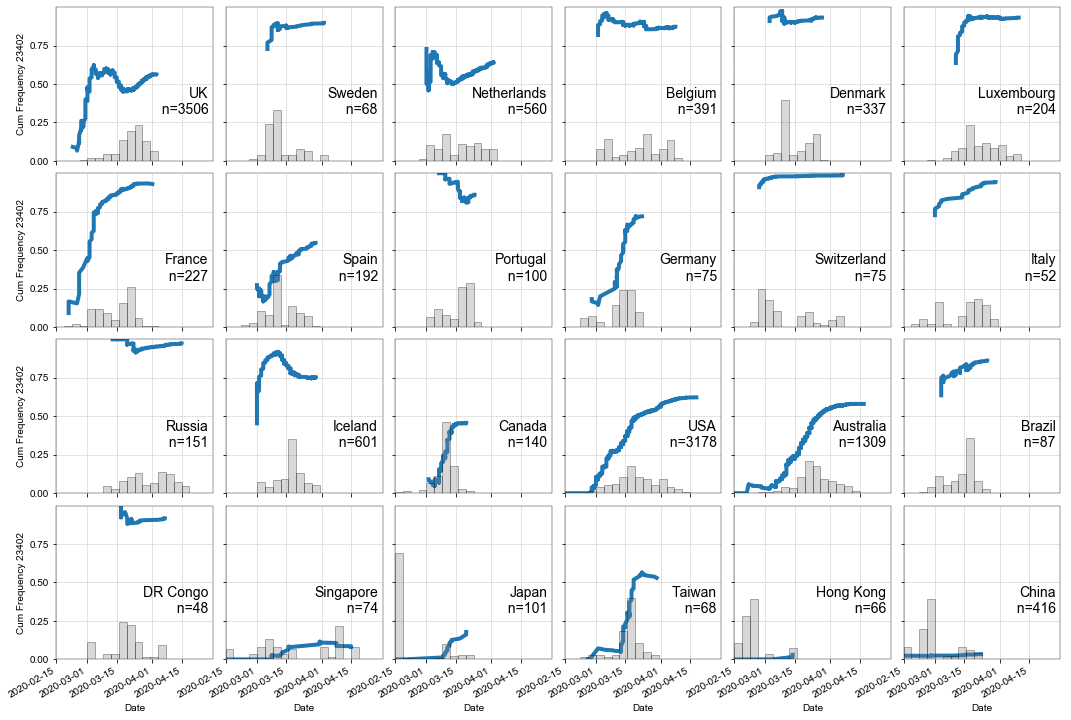

In [302]:
array_freqs(df=df2, countries=countries, fs_l=14, lw=4, savepath="./figures/dumpster/arr_countries.png")

In [313]:
df2["division"].value_counts()[:40]

England                 2430
Washington              1183
Victoria                1057
New York                 768
Wales                    678
Reykjavik                601
Scotland                 396
Denmark                  330
Netherlands              296
Wisconsin                271
New South Wales          211
Luxembourg               204
Liège                    190
Guangdong                149
Connecticut              139
California               136
South Holland            103
Comunitat Valenciana      99
Portugal                  98
Utah                      97
North Brabant             96
Shanghai                  96
Auvergne-Rhône-Alpes      85
Saint-Petersburg          84
Arizona                   83
Virginia                  80
Minnesota                 80
Singapore                 74
Madrid                    74
Japan                     72
Hong Kong                 66
Ile de France             61
British Columbia          59
Ontario                   59
Hauts de Franc

Saved to ./figures/dumpster/arr_us.png


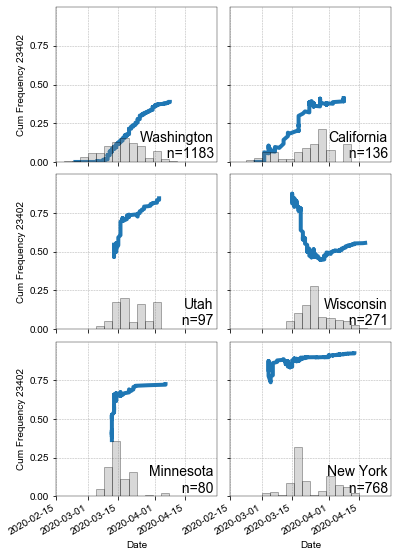

In [326]:
regions = ["Washington", "California", "Utah", "Wisconsin", "Minnesota", "New York"]
array_freqs(df=df2, countries=regions, col="division", fs_l=14, lw=4, 
            n_col =2, n_row = 3, txt_xy=(0.98, 0.2),
            savepath="./figures/dumpster/arr_us.png")